In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Load the data

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [3]:
y.shape, tx.shape

((10000,), (10000, 2))

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_loss` function below:

In [4]:
def compute_loss(y, tx, w, loss_type = "MSE"):
    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    e = y - tx @ w
    N = len(y)
        
    MAE = 1/N * sum(np.abs(e[i]) for i in range(N))
    MSE = 1/(2*N) * (e @ e)
    MSE2 = 1/(2*N) * sum(e[i]**2 for i in range(N)) # equivalent
    
    if loss_type == 'MSE' : 
        return MSE
    else : 
        return MAE
    raise ValueError("Loss type should be MSE or MAE")

In [5]:
# TEST on small dataset : N=2
y  = np.array([1, 2])
tx = np.array([[1, 1],   # first row: [1, x1] = [1, 1]
               [1, 2]])  # second row: [1, x2] = [1, 2]
w  = np.array([0, 1])    # w0=0, w1=1

print("MSE:", compute_loss(y, tx, w, "MSE"))   # expect 0
print("MAE:", compute_loss(y, tx, w, "MAE"))   # expect 0

# change weights a bit
w = np.array([0, 0])  # predict constant 0 ; e = [1,2] - [0,0] = [1,2]

print("MSE:", compute_loss(y, tx, w, "MSE"))   # (1^2+2^2)/(2*2)=5/4=1.25
print("MAE:", compute_loss(y, tx, w, "MAE"))   # (|1|+|2|)/2=1.5

MSE: 0.0
MAE: 0.0
MSE: 1.25
MAE: 1.5


# 2. Grid Search

Fill in the function `grid_search()` below:

In [6]:
# from costs import *

def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute loss for each combination of w0 and w1.
    # ***************************************************

    losses = np.zeros((len(grid_w0), len(grid_w1)))

    n = len(grid_w0)
    m = len(grid_w1)

    for i, w0 in enumerate(grid_w0) : 
        for j, w1 in enumerate(grid_w1) : 
            w = np.array([grid_w0[i], grid_w1[j]])
            # w = np.array([w0,w1])
            losses[i,j] = compute_loss(y, tx, w)
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=62.36111111111123, w0*=33.33333333333334, w1*=-16.666666666666657, execution time=0.002 seconds


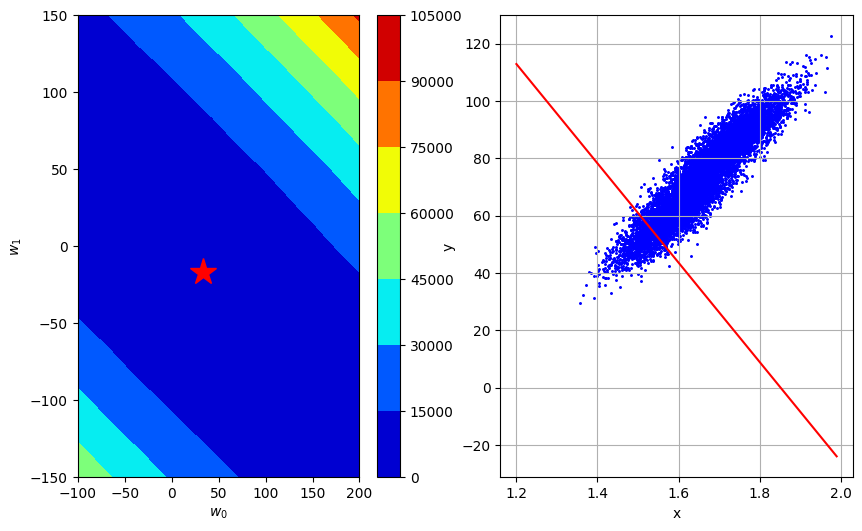

In [7]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=10)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print(
    "Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
        l=loss_star, w0=w0_star, w1=w1_star, t=execution_time
    )
)

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)
fig.savefig("grid_plot")  # Optional saving

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [8]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute gradient vector
    # ***************************************************
    N = y.shape[0]
    e = y - tx @ w
    grad_L = - 1/N * tx.T @ e
    return grad_L

In [9]:
# test
y = np.array([1.0, 2.0, 3.0])
tx = np.c_[np.ones(3), np.array([1.0, 2.0, 3.0])]  # design matrix with intercept
w = np.array([0.5, -0.5])  # arbitrary test weights

# analytical gradient
grad = compute_gradient(y, tx, w)
print("Analytical gradient:", grad)

# numerical gradient
eps = 1e-6
num_grad = np.zeros_like(w)
for i in range(len(w)):
    w_eps = w.copy()
    w_eps[i] += eps
    loss_plus = compute_loss(y, tx, w_eps)
    
    w_eps = w.copy()
    w_eps[i] -= eps
    loss_minus = compute_loss(y, tx, w_eps)
    
    num_grad[i] = (loss_plus - loss_minus) / (2 * eps)
print("Numerical gradient :", num_grad)

Analytical gradient: [-2.5 -6. ]
Numerical gradient : [-2.5 -6. ]


Please fill in the functions `gradient_descent` below:

In [31]:
def gradient_descent(y, tx, initial_w, max_iters, gamma, loss_type = "MSE"):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters + 1 containing the model parameters as numpy arrays of shape (2, ),
            for each iteration of GD (as well as the final weights)
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = [compute_loss(y,tx,initial_w)] # compute loss for initial w as well
    w = initial_w
    for n_iter in range(max_iters):
        # compute grad
        grad_L = compute_gradient(y,tx,w)  
        # update weights, compute loss for new weights
        w = w - gamma * grad_L
        loss = compute_loss(y,tx,w, loss_type)
        
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [32]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=267.05002587794206, w0=51.5425907218118, w1=10.132993413506089
GD iter. 1/49: loss=36.45002800750026, w0=67.00536793835533, w1=13.172891437557828
GD iter. 2/49: loss=15.696028199160638, w0=71.64420110331838, w1=14.084860844773322
GD iter. 3/49: loss=13.828168216410079, w0=73.03585105280729, w1=14.358451666937963
GD iter. 4/49: loss=13.660060817962522, w0=73.45334603765397, w1=14.440528913587354
GD iter. 5/49: loss=13.644931152102245, w0=73.57859453310797, w1=14.46515208758217
GD iter. 6/49: loss=13.643569482174819, w0=73.61616908174418, w1=14.472539039780616
GD iter. 7/49: loss=13.643446931881353, w0=73.62744144633503, w1=14.474755125440149
GD iter. 8/49: loss=13.643435902354936, w0=73.63082315571229, w1=14.47541995113801
GD iter. 9/49: loss=13.643434909697557, w0=73.63183766852546, w1=14.475619398847368
GD iter. 10/49: loss=13.643434820358397, w0=73.63214202236942, w1=14.475679233160175
GD iter. 11/49: loss=13.643434812317876, w0=73.6322333285226, w1=14.47569718345

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

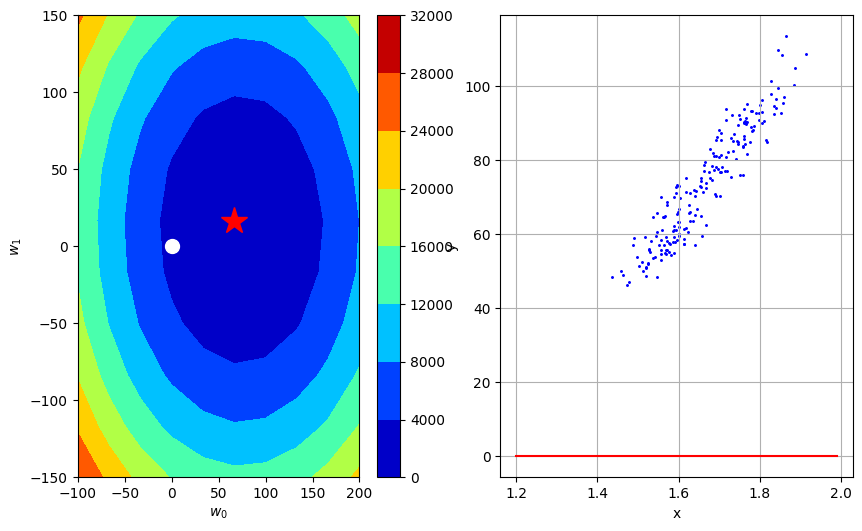

In [33]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

# 4. Stochastic gradient descent

In [34]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """
    # same as before, gradient computation
    e = y - tx@w
    N = y.shape[0]
    grad_L = -1/N * tx.T @ e
    return grad_L


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = [compute_loss(y,tx,initial_w)]
    w = initial_w.copy()

    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic gradient descent.
        # ***************************************************
        for y_batch, tx_batch in batch_iter(y,tx,batch_size, num_batches=1, shuffle=True):
            # compute gradient of loss on this mini-batch
            grad_L = compute_stoch_gradient(y_batch, tx_batch,w)

            # update weights and compute loss
            w = w - gamma*grad_L
            loss = compute_loss(y,tx,w) # full loss, not just batch loss

            # save loss and weights for this iteration
            losses.append(loss)
            ws.append(w)

        print(
            "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [35]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=2457.0998668797374, w0=6.7921376136294755, w1=-6.001336850613565
SGD iter. 1/49: loss=1721.5642129899513, w0=16.108032099535922, w1=4.1411353479398505
SGD iter. 2/49: loss=1506.9895826333313, w0=21.530557584390994, w1=-2.0198582449714833
SGD iter. 3/49: loss=1033.0247227078298, w0=28.953088959346555, w1=7.953961433800225
SGD iter. 4/49: loss=796.0486038946599, w0=34.0843661552099, w1=13.59624760340694
SGD iter. 5/49: loss=635.0368965674018, w0=38.443471035108416, w1=16.605300568165934
SGD iter. 6/49: loss=538.903707003162, w0=41.623133074000364, w1=19.568399660943594
SGD iter. 7/49: loss=426.0336715145216, w0=44.95951316517396, w1=16.104614893099875
SGD iter. 8/49: loss=353.10749801515266, w0=47.65782952844958, w1=16.53881922539097
SGD iter. 9/49: loss=262.7390265702791, w0=51.314481721497714, w1=14.147985359263835
SGD iter. 10/49: loss=225.40651623098583, w0=53.20866365900837, w1=11.94541509185376
SGD iter. 11/49: loss=201.82682492518302, w0=54.89156436770422, w1=

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

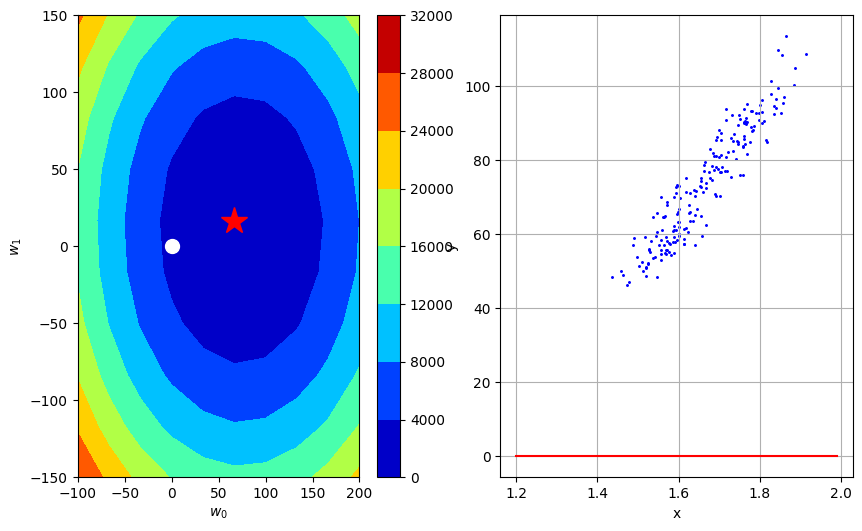

In [36]:
# Time Visualization
from ipywidgets import IntSlider, interact

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses,
        sgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

# 5. Effect of Outliers and MAE Cost Function

## Without outliers

In [37]:
import datetime
from helpers import *

# load the data by subsampling first, then by subsampling and adding outliers
height, weight, gender = load_data(sub_sample=True, add_outlier = False)

x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)
y.shape, tx.shape

((200,), (200, 2))

In [43]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

# fit with GD
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma, "MSE")

# background loss grid for contours (on the SAME data)
grid_w0, grid_w1 = generate_w(num_intervals=10)
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD (no outliers): execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=267.05002587794206, w0=51.5425907218118, w1=10.132993413506089
GD iter. 1/49: loss=36.45002800750026, w0=67.00536793835533, w1=13.172891437557828
GD iter. 2/49: loss=15.696028199160638, w0=71.64420110331838, w1=14.084860844773322
GD iter. 3/49: loss=13.828168216410079, w0=73.03585105280729, w1=14.358451666937963
GD iter. 4/49: loss=13.660060817962522, w0=73.45334603765397, w1=14.440528913587354
GD iter. 5/49: loss=13.644931152102245, w0=73.57859453310797, w1=14.46515208758217
GD iter. 6/49: loss=13.643569482174819, w0=73.61616908174418, w1=14.472539039780616
GD iter. 7/49: loss=13.643446931881353, w0=73.62744144633503, w1=14.474755125440149
GD iter. 8/49: loss=13.643435902354936, w0=73.63082315571229, w1=14.47541995113801
GD iter. 9/49: loss=13.643434909697557, w0=73.63183766852546, w1=14.475619398847368
GD iter. 10/49: loss=13.643434820358397, w0=73.63214202236942, w1=14.475679233160175
GD iter. 11/49: loss=13.643434812317876, w0=73.6322333285226, w1=14.47569718345

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

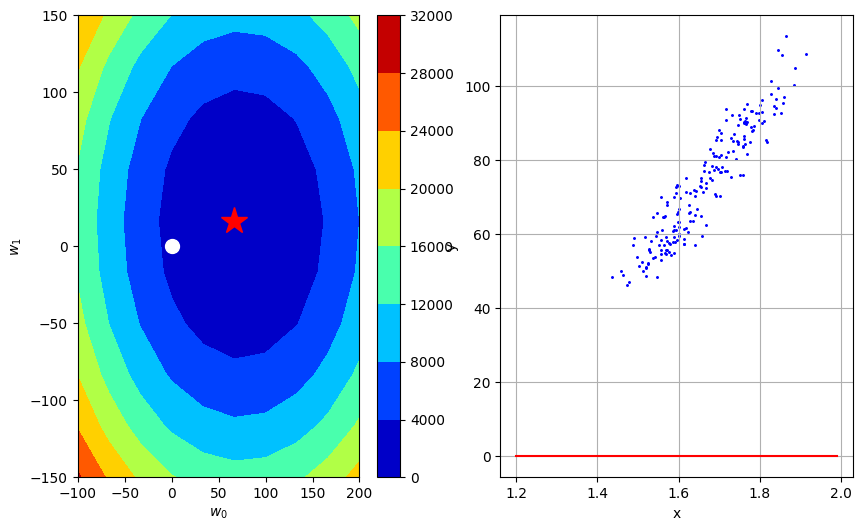

In [39]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)
    return fig

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

## With outliers

In [ ]:
# Hyperparameters (reuse or adjust if needed)
max_iters = 50
gamma = 0.7
w_initial = np.array([0.0, 0.0])

# Load & preprocess (with outliers)
height_o, weight_o, gender_o = load_data(sub_sample=True, add_outlier=True)
x_o, mean_x_o, std_x_o = standardize(height_o)
y_o, tx_o = build_model_data(x_o, weight_o)

# Fit with GD
start_time = datetime.datetime.now()
gd_losses_o, gd_ws_o = gradient_descent(y_o, tx_o, w_initial, max_iters, gamma, loss_type = 'MAE')
end_time = datetime.datetime.now()

# Background loss grid (same dataset)
grid_w0_o, grid_w1_o = generate_w(num_intervals=10)
grid_losses_o = grid_search(y_o, tx_o, grid_w0_o, grid_w1_o)

# Print timing
execution_time_o = (end_time - start_time).total_seconds()
print(f"GD (with outliers): execution time={execution_time_o:.3f} seconds")

# Interactive visualization (uses the course plotting util)
def plot_figure_o(n_iter):
    fig = gradient_descent_visualization(
        gd_losses_o,
        gd_ws_o,
        grid_losses_o,
        grid_w0_o,
        grid_w1_o,
        mean_x_o,
        std_x_o,
        height_o,
        weight_o,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)
    return fig

# Slider: adjust bounds to how your visualization indexes iterations
interact(plot_figure_o, n_iter=IntSlider(min=1, max=len(gd_ws_o)))

We observe that changing the loss from MSE to MAE improves the loss dramatically. It is because the squaring in MSE gives way too much weight and importance to the outliers, which end up skewing a lot the model (the linear regression). That is why when we have outliers, using MAE as a loss function instead of MSE might be a more robust alternative.

# 6. Subgradient descent

In [51]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    e = y - tx@w
    s = np.sign(e)
    s[e==0] = 0
    N = y.shape[0]
    return -1/N*(tx.T @ s)
    


In [58]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD
    """
    # Define parameters to store w and loss
    loss_type = "MAE"
    ws = [initial_w]
    losses = [compute_loss(y,tx,initial_w,loss_type)] # initialize with loss of initial w vector
    w = initial_w.copy()
    
    for n_iter in range(max_iters):

        subgr_L = compute_subgradient_mae(y,tx,w)
        w = w - gamma*subgr_L
        loss = compute_loss(y,tx,w,loss_type) # loss of new w vector

        
        ws.append(w)
        losses.append(loss)
        print(
            "SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

In [59]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

SubGD iter. 0/499: loss=72.93227245973117, w0=0.7, w1=1.6071588504473765e-15
SubGD iter. 1/499: loss=72.2322724597311, w0=1.4, w1=3.214317700894753e-15
SubGD iter. 2/499: loss=71.53227245973117, w0=2.0999999999999996, w1=4.8214765513421295e-15
SubGD iter. 3/499: loss=70.8322724597312, w0=2.8, w1=6.428635401789506e-15
SubGD iter. 4/499: loss=70.13227245973108, w0=3.5, w1=8.035794252236883e-15
SubGD iter. 5/499: loss=69.43227245973115, w0=4.2, w1=9.642953102684259e-15
SubGD iter. 6/499: loss=68.7322724597311, w0=4.9, w1=1.1250111953131636e-14
SubGD iter. 7/499: loss=68.03227245973119, w0=5.6000000000000005, w1=1.2857270803579012e-14
SubGD iter. 8/499: loss=67.3322724597312, w0=6.300000000000001, w1=1.446442965402639e-14
SubGD iter. 9/499: loss=66.6322724597311, w0=7.000000000000001, w1=1.6071588504473765e-14
SubGD iter. 10/499: loss=65.93227245973115, w0=7.700000000000001, w1=1.767874735492114e-14
SubGD iter. 11/499: loss=65.2322724597311, w0=8.4, w1=1.9285906205368518e-14
SubGD iter. 12

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

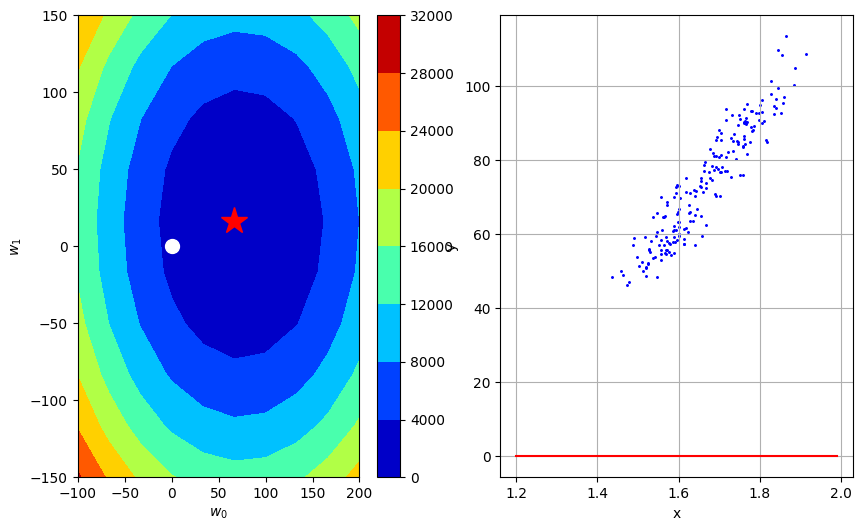

In [61]:
from ipywidgets import IntSlider, interact

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses,
        subgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)
    return fig


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [69]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Compute a stochastic subgradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD
    """

    # Define parameters to store w and loss
    loss_type = "MAE"
    ws = [initial_w]
    losses = [compute_loss(y,tx,initial_w, loss_type)]
    w = initial_w.copy()

    for n_iter in range(max_iters):

        for y_batch, tx_batch in batch_iter(y,tx,batch_size,num_batches=1, shuffle=True) :
            stochastic_subgrad_L = compute_subgradient_mae(y_batch,tx_batch,w)
            w = w - gamma* stochastic_subgrad_L
            loss = compute_loss(y,tx,w, loss_type)

            losses.append(loss)
            ws.append(w)

        print(
            "SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [70]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 2

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

SubSGD iter. 0/499: loss=72.93227245973114, w0=0.7, w1=-0.27832808345507354
SubSGD iter. 1/499: loss=72.23227245973116, w0=1.4, w1=0.11867602600884869
SubSGD iter. 2/499: loss=71.53227245973119, w0=2.0999999999999996, w1=-0.49215227722057536
SubSGD iter. 3/499: loss=70.83227245973113, w0=2.8, w1=0.048377443059338276
SubSGD iter. 4/499: loss=70.13227245973123, w0=3.5, w1=0.2869042897276447
SubSGD iter. 5/499: loss=69.43227245973114, w0=4.2, w1=-0.32392401350177935
SubSGD iter. 6/499: loss=68.73227245973116, w0=4.9, w1=-0.6384353424674455
SubSGD iter. 7/499: loss=68.03227245973112, w0=5.6000000000000005, w1=0.41358872961262716
SubSGD iter. 8/499: loss=67.33227245973113, w0=6.300000000000001, w1=0.7644958481955213
SubSGD iter. 9/499: loss=66.63227245973115, w0=7.000000000000001, w1=1.2205310743933513
SubSGD iter. 10/499: loss=65.93227245973118, w0=7.700000000000001, w1=0.41526462384966134
SubSGD iter. 11/499: loss=65.23227245973118, w0=8.4, w1=0.9247766097514212
SubSGD iter. 12/499: loss=

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

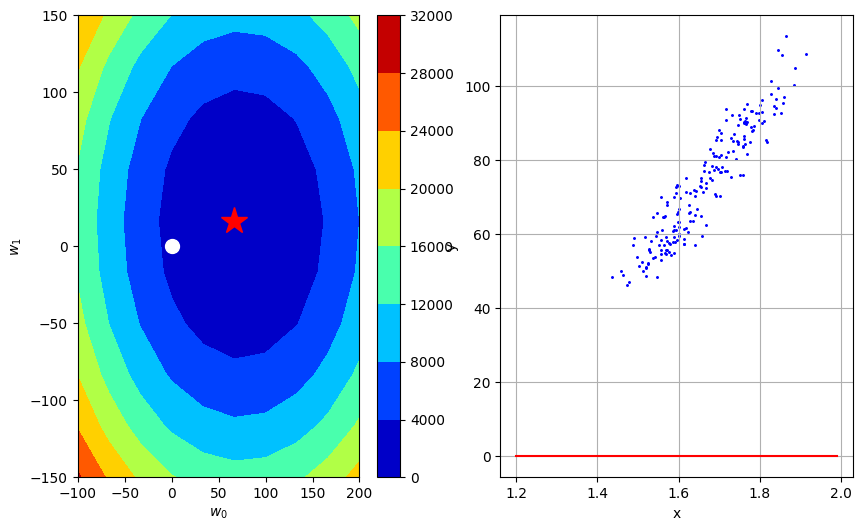

In [68]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses,
        subsgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)
    return fig


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))